
# 🧠 From Intuition to Simulation: Exploring the Leaky Integrate-and-Fire Neuron with Brian2
---
# by Prof Akinola S. Olayinka

---



### 🛠 Installation Instructions (Anaconda or pip)

To run this notebook, you need the following Python packages:

- brian2 (for LIF neuron simulation)
- numpy (for numerical operations)
- matplotlib (for plotting)
- pynwb (for reading DANDI data in NWB format, if using real data) if required .

---

#### 📦 Option 1: Using pip (standard Python environment)

bash
pip install brian2 numpy matplotlib pynwb jupyterlab


If you encounter a warning like:


Cannot use Cython... 'basetsd.h': No such file or directory


It means your system lacks Microsoft C++ Build Tools. You can either:

- Ignore it and force Brian2 to use NumPy backend:
python
-  from brian2 import prefs
-  prefs.codegen.target = "numpy"
  
- Or install the build tools from [https://visualstudio.microsoft.com/visual-cpp-build-tools/](https://visualstudio.microsoft.com/visual-cpp-build-tools/)

---

#### 🐍 Option 2: Using Anaconda (recommended for Windows users)

If you use Anaconda, you can create an environment with all dependencies:

bash
- conda create -n LIF-Brian2 python=3.10
- conda activate LIF-Brian2
- conda install -c conda-forge brian2 pynwb matplotlib jupyterlab jaraco.classes

This will handle compiler issues automatically in most cases.

You can now run the notebook inside this environment without problems.

---
---

# Leaky Integrate-and-Fire (LIF) Neuron Simulation

This notebook accompanies Prof. Akinola Olayinka's lecture on computational neuroscience at BioRTC, Yobe State University.

We'll implement and explore:
1. The passive membrane model
2. Basic integrate-and-fire (IF) model
3. Leaky integrate-and-fire (LIF) model
4. Generalized LIF (gLIF) with adaptation
5. Simulate Neurons with Brian2

---

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid') 

---
# 1. Passive Membrane Model
---

First, let's implement the passive membrane equation from the lecture:

$$\frac{dV_m}{dt} = -\frac{1}{\tau}(V_m - V_{\text{rest}}) + \frac{I_{\text{ext}}}{C}$$

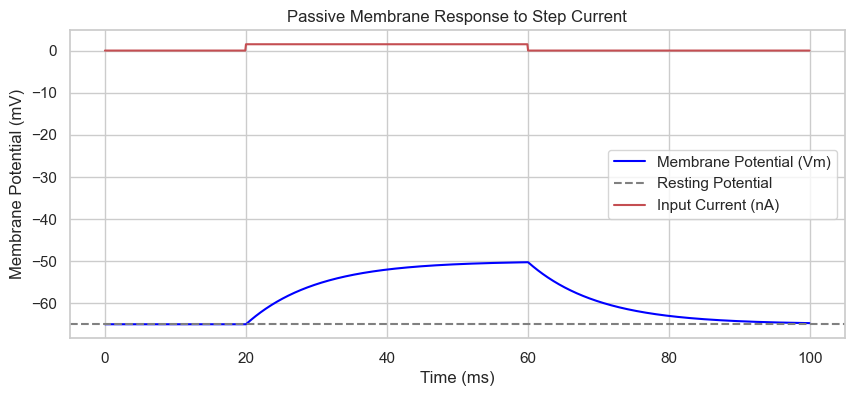

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def passive_membrane(V_rest, tau, C, I_ext, duration=100, dt=0.1):
    """
    Simulate passive membrane potential dynamics using Euler's method.
    
    Parameters:
    - V_rest: Resting membrane potential (mV)
    - tau: Membrane time constant (ms)
    - C: Membrane capacitance (nF)
    - I_ext: External input current array (nA), same length as simulation time
    - duration: Total simulation time (ms)
    - dt: Time step size (ms)
    
    Returns:
    - time: Array of time points
    - Vm: Array of membrane potential values over time
    """
    time = np.arange(0, duration, dt)  # Create time array
    Vm = np.zeros_like(time)           # Initialize membrane potential array
    Vm[0] = V_rest                     # Set initial value to resting potential
    
    # Loop over time steps and update voltage using Euler integration
    for t in range(1, len(time)):
        # Compute change in voltage:
        # dV = leak term + input term = [-(V - V_rest)/tau + I/C]
        dV = (-(Vm[t-1] - V_rest)/tau + I_ext[t-1]/C)
        Vm[t] = Vm[t-1] + dV * dt      # Euler step: V(t+1) = V(t) + dV * dt
        
    return time, Vm

# ------------------------------------------------
# Define simulation parameters
# ------------------------------------------------
V_rest = -65        # Resting membrane potential (mV)
tau = 10            # Membrane time constant (ms)
C = 1               # Capacitance (nF)
duration = 100      # Total simulation time (ms)
dt = 0.1            # Time step (ms)

# ------------------------------------------------
# Create external input current: step input at 20–60 ms
# ------------------------------------------------
I_ext = np.zeros(int(duration/dt))       # Initialize current array (0 nA)
I_ext[int(20/dt):int(60/dt)] = 1.5       # Apply 1.5 nA from 20 ms to 60 ms

# ------------------------------------------------
# Run the simulation
# ------------------------------------------------
time, Vm = passive_membrane(V_rest, tau, C, I_ext, duration, dt)

# ------------------------------------------------
# Plot the results
# ------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(time, Vm, label='Membrane Potential (Vm)', color='blue')     # Vm over time
plt.axhline(V_rest, color='gray', linestyle='--', label='Resting Potential')  # Horizontal line at V_rest
plt.plot(time, I_ext, 'r', label='Input Current (nA)')                 # Show input current
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Passive Membrane Response to Step Current')
plt.legend()
plt.grid(True)
plt.show()


### Observations:
- The membrane potential rises when current is applied
- It decays back to rest when current stops
- No spiking occurs (purely passive)

---
# 2. Integrate-and-Fire (IF) Model
---

Now let's implement the basic IF model which lacks the leak term:

$$\frac{dV_m}{dt} = \frac{I_{\text{ext}}}{C}$$

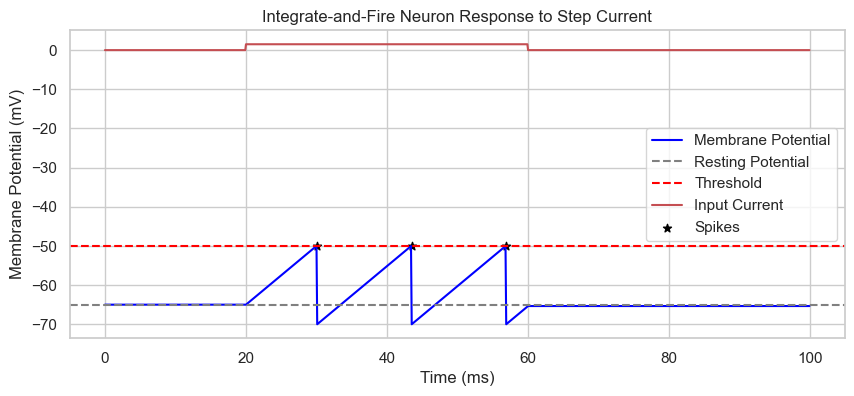

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def integrate_fire(V_rest, V_th, V_reset, C, I_ext, duration=100, dt=0.1):
    """
    Simulate a basic Integrate-and-Fire (IF) neuron without a leak term.
    
    Parameters:
    - V_rest: Resting potential (mV)
    - V_th: Threshold potential (mV) — triggers a spike
    - V_reset: Membrane potential reset after spike (mV)
    - C: Membrane capacitance (nF)
    - I_ext: External input current array (nA)
    - duration: Total simulation time (ms)
    - dt: Time step for integration (ms)

    Returns:
    - time: Array of time points
    - Vm: Membrane potential over time
    - spikes: List of times when spikes occur
    """
    time = np.arange(0, duration, dt)  # Create time vector
    Vm = np.zeros_like(time)           # Initialize membrane potential vector
    Vm[0] = V_rest                     # Set initial potential to resting value
    spikes = []                        # Store spike times
    
    # Time loop using Euler method to integrate voltage
    for t in range(1, len(time)):
        dV = I_ext[t-1] / C                     # dv/dt = I / C for integrate-only model
        Vm[t] = Vm[t-1] + dV * dt               # Update voltage using Euler's method
        
        # Check for spike
        if Vm[t] >= V_th:
            spikes.append(time[t])             # Record the spike time
            Vm[t] = V_reset                    # Reset voltage after spike
    
    return time, Vm, spikes

# ------------------------------------------------
# Parameters
# ------------------------------------------------
V_rest = -65       # Resting potential (mV)
V_th = -50         # Firing threshold (mV)
V_reset = -70      # Reset value after spike (mV)
C = 1              # Membrane capacitance (nF)
duration = 100     # Total simulation time (ms)
dt = 0.1           # Time step (ms)

# ------------------------------------------------
# External input current (step input between 20–60 ms)
# ------------------------------------------------
I_ext = np.zeros(int(duration/dt))          # Initialize input current array
I_ext[int(20/dt):int(60/dt)] = 1.5          # Apply 1.5 nA during 20–60 ms

# ------------------------------------------------
# Run simulation
# ------------------------------------------------
time, Vm, spikes = integrate_fire(V_rest, V_th, V_reset, C, I_ext, duration, dt)

# ------------------------------------------------
# Plotting results
# ------------------------------------------------
plt.figure(figsize=(10, 4))

# Plot membrane potential trace
plt.plot(time, Vm, label='Membrane Potential', color='blue')

# Add horizontal lines for resting and threshold levels
plt.axhline(V_rest, color='gray', linestyle='--', label='Resting Potential')
plt.axhline(V_th, color='red', linestyle='--', label='Threshold')

# Plot external current on same graph
plt.plot(time, I_ext, 'r', label='Input Current')

# Mark spike times on threshold line
plt.scatter(spikes, [V_th]*len(spikes), color='black', marker='*', label='Spikes')

# Labeling and formatting
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Integrate-and-Fire Neuron Response to Step Current')
plt.legend()
plt.grid(True)
plt.show()

### Observations:
- Without leak, potential keeps integrating input
- Spikes occur when threshold is crossed
- After spike, potential resets
- Not very biologically realistic

---
# 3. Leaky Integrate-and-Fire (LIF) Model
---

Now we'll implement the LIF model which combines leak and spiking:

$$\frac{dV_m}{dt} = -\frac{1}{\tau}(V_m - V_{\text{rest}}) + \frac{I_{\text{ext}}}{C}$$

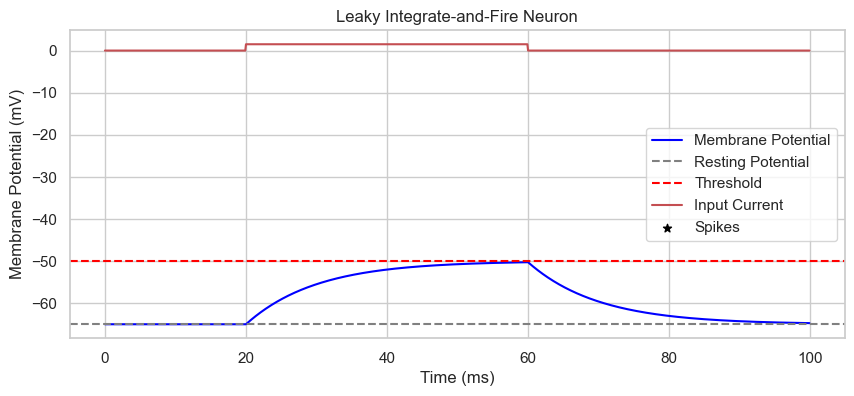

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def lif_neuron(V_rest, V_th, V_reset, tau, C, I_ext, duration=100, dt=0.1):
    """
    Simulate a Leaky Integrate-and-Fire (LIF) neuron using Euler integration.
    
    Parameters:
    - V_rest: Resting membrane potential (mV)
    - V_th: Threshold potential for firing a spike (mV)
    - V_reset: Reset potential after a spike (mV)
    - tau: Membrane time constant (ms)
    - C: Membrane capacitance (nF)
    - I_ext: External input current array (nA)
    - duration: Total simulation time (ms)
    - dt: Time step for numerical integration (ms)
    
    Returns:
    - time: Array of time points (ms)
    - Vm: Membrane potential over time (mV)
    - spikes: List of spike times (ms)
    """
    time = np.arange(0, duration, dt)    # Create time vector
    Vm = np.zeros_like(time)             # Initialize voltage array
    Vm[0] = V_rest                       # Set initial membrane potential
    spikes = []                          # Store spike times here

    # Loop through each time step to update membrane potential
    for t in range(1, len(time)):
        # Compute change in voltage using LIF differential equation:
        # dV/dt = [-(V - V_rest)/tau + I/C]
        dV = (-(Vm[t-1] - V_rest)/tau + I_ext[t-1]/C)
        Vm[t] = Vm[t-1] + dV * dt        # Euler update: V(t+1) = V(t) + dV*dt
        
        # Check if voltage crosses threshold
        if Vm[t] >= V_th:
            spikes.append(time[t])      # Record spike time
            Vm[t] = V_reset              # Reset voltage after spike
    
    return time, Vm, spikes

# -----------------------------------------------------
# Example parameters for simulation
# -----------------------------------------------------
V_rest = -65      # Resting potential (mV)
V_th = -50        # Spike threshold (mV)
V_reset = -70     # Reset potential (mV)
tau = 10          # Membrane time constant (ms)
C = 1             # Capacitance (nF)
duration = 100    # Total simulation time (ms)
dt = 0.1          # Time step (ms)

# -----------------------------------------------------
# Create external input: Step current between 20 ms and 60 ms
# -----------------------------------------------------
I_ext = np.zeros(int(duration/dt))          # Initialize current array
I_ext[int(20/dt):int(60/dt)] = 1.5          # Apply constant current (1.5 nA) for 40 ms

# -----------------------------------------------------
# Run the LIF simulation
# -----------------------------------------------------
time, Vm, spikes = lif_neuron(V_rest, V_th, V_reset, tau, C, I_ext, duration, dt)

# -----------------------------------------------------
# Plot the membrane potential and spike times
# -----------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(time, Vm, label='Membrane Potential', color='blue')  # Vm trace
plt.axhline(V_rest, color='gray', linestyle='--', label='Resting Potential')  # Rest line
plt.axhline(V_th, color='red', linestyle='--', label='Threshold')             # Threshold line
plt.plot(time, I_ext, 'r', label='Input Current')                             # Input current
plt.scatter(spikes, [V_th]*len(spikes), color='black', marker='*', label='Spikes')  # Spike markers

plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Leaky Integrate-and-Fire Neuron')
plt.legend()
plt.grid(True)
plt.show()


### Observations:
- More biologically realistic than IF
- Potential leaks back toward rest between inputs
- Spiking occurs when threshold is crossed
- After spike, potential resets

---
# 4. Exploring Parameter Effects
---

Let's see how changing parameters affects the neuron's behavior.

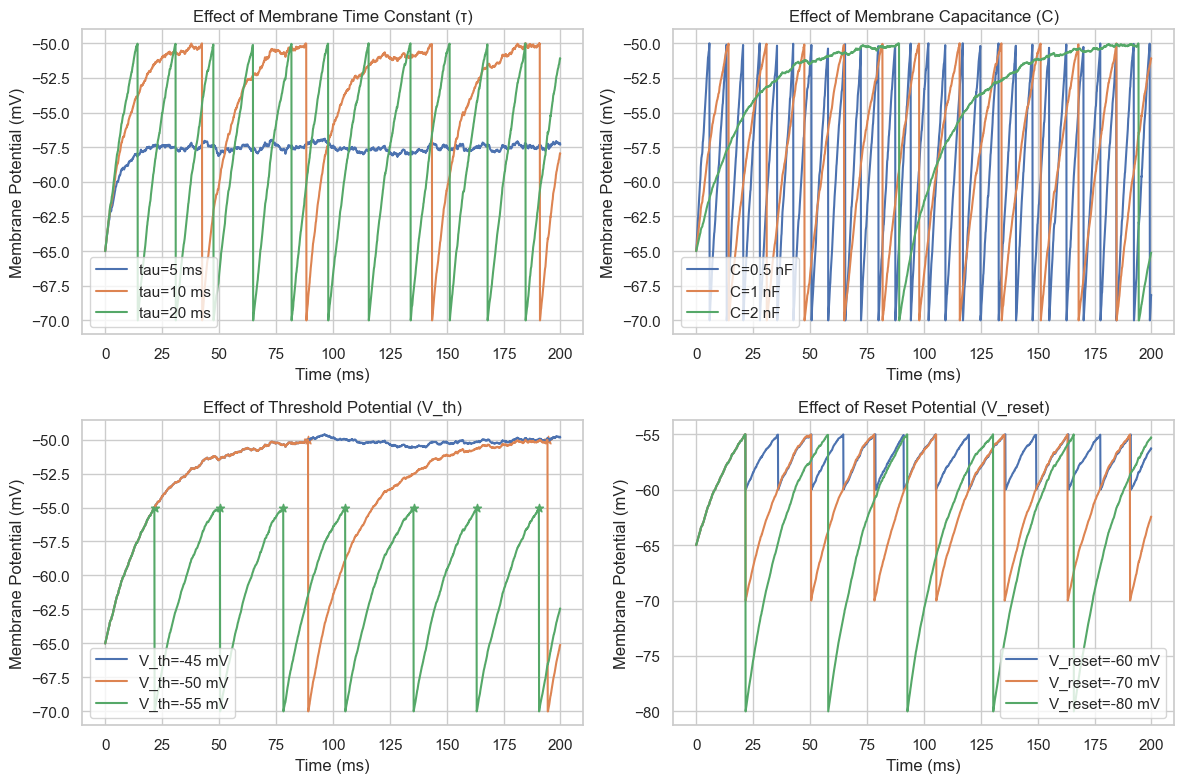

In [5]:
# ------------------------------------------------------------
# Create a more interesting and realistic input current
# ------------------------------------------------------------
duration = 200                           # Total duration of simulation (ms)
time = np.arange(0, duration, dt)       # Time array based on chosen time step
# Generate noisy input current: mean = 1.5 nA, std = 0.5 nA
I_ext = np.random.normal(1.5, 0.5, len(time))  # This mimics fluctuating synaptic input

# ------------------------------------------------------------
# Set up a 2x2 grid of subplots to explore different parameters
# ------------------------------------------------------------
plt.figure(figsize=(12, 8))

# ------------------------------------------------------------
# SUBPLOT 1: Effect of varying membrane time constant (tau)
# ------------------------------------------------------------
plt.subplot(221)
for tau in [5, 10, 20]:  # Explore short, medium, and long tau values
    _, Vm, _ = lif_neuron(V_rest, V_th, V_reset, tau, C, I_ext, duration, dt)
    plt.plot(time, Vm, label=f'tau={tau} ms')
plt.title('Effect of Membrane Time Constant (τ)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid(True)

# ------------------------------------------------------------
# SUBPLOT 2: Effect of varying membrane capacitance (C)
# ------------------------------------------------------------
plt.subplot(222)
for C in [0.5, 1, 2]:  # Smaller and larger capacitances change how fast the neuron integrates input
    _, Vm, _ = lif_neuron(V_rest, V_th, V_reset, tau, C, I_ext, duration, dt)
    plt.plot(time, Vm, label=f'C={C} nF')
plt.title('Effect of Membrane Capacitance (C)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid(True)

# ------------------------------------------------------------
# SUBPLOT 3: Effect of varying spike threshold (V_th)
# ------------------------------------------------------------
plt.subplot(223)
for V_th in [-45, -50, -55]:  # Easier or harder to spike depending on the threshold level
    _, Vm, spikes = lif_neuron(V_rest, V_th, V_reset, tau, C, I_ext, duration, dt)
    plt.plot(time, Vm, label=f'V_th={V_th} mV')
    plt.scatter(spikes, [V_th]*len(spikes), marker='*')  # Mark spike times with stars
plt.title('Effect of Threshold Potential (V_th)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid(True)

# ------------------------------------------------------------
# SUBPLOT 4: Effect of varying reset potential (V_reset)
# ------------------------------------------------------------
plt.subplot(224)
for V_reset in [-60, -70, -80]:  # Higher reset = quicker rebound; lower reset = longer recovery
    _, Vm, spikes = lif_neuron(V_rest, V_th, V_reset, tau, C, I_ext, duration, dt)
    plt.plot(time, Vm, label=f'V_reset={V_reset} mV')
plt.title('Effect of Reset Potential (V_reset)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid(True)

# ------------------------------------------------------------
# Adjust layout and show the figure
# ------------------------------------------------------------
plt.tight_layout()
plt.show()


### 🧠 Exploring LIF Neuron Dynamics with Noisy Input

This simulation shows how the **Leaky Integrate-and-Fire (LIF)** neuron responds to a noisy input current under different model parameters.

#### 🔍 What the Code Does:
- **Input Current (`I_ext`)**: Randomly generated using a normal distribution, simulating fluctuating synaptic input.
- **Subplots**: The code generates four subplots showing the effect of changing:
  - **Membrane Time Constant (τ)**: Controls how fast the neuron integrates input.
  - **Capacitance (C)**: Influences how much input is needed to change voltage.
  - **Threshold Voltage (V_th)**: Determines how easily the neuron fires.
  - **Reset Potential (V_reset)**: Voltage to which the neuron resets after firing.

Each variation reveals how that specific parameter shapes the neuron's spiking behavior and voltage trace.

---

### 🧪 Exercises for Exploration

#### 🔬 **Exercise 1: Effect of Input Strength**
> **Task**: Modify the line that generates `I_ext` to increase the input current:
>
> ```python
> I_ext = np.random.normal(3, 0.5, len(time))
> ```
>
> - How does this affect the number and timing of spikes?
> - Which parameter's influence becomes more or less noticeable?

---

#### 🔄 **Exercise 2: Compare Fast vs. Slow Neurons**
> **Focus**: Top-left subplot (membrane time constant τ)
>
> - Which τ value leads to quicker voltage changes?
> - Which τ value leads to more frequent spikes?
> - What would happen with an even smaller τ (e.g., 1 ms)?

---

#### 🎯 **Exercise 3: Identify Spiking Thresholds**
> **Focus**: Bottom-left subplot (spike threshold V_th)
>
> - Count the number of spikes for each V_th value.
> - Which threshold is most likely to produce frequent spiking?
> - Try adding `-60` to the list of V_th values. What happens?

---

#### 🔧 **Exercise 4: Design Your Own Parameter Sweep**
> **Your Turn**: Choose one parameter to vary (e.g., resting potential, input noise level, or input duration).
>
> - Modify the code to sweep it over at least **three values**.
> - Plot the voltage traces and compare.
> - Use `plt.subplot()` to organize your plots if needed.
>
> **Bonus**: Try combining two parameters and observing their interaction.

---

💡 *Tip: Document your findings in separate markdown cells after each experiment. Share and discuss with your peers!*

---
# 5. Optional: Generalized LIF (gLIF) with Adaptation
---

Extending the LIF model with spike-triggered adaptation:

$$\tau \frac{dV_m}{dt} = -(V_m - V_{\text{rest}}) + \frac{I_{\text{ext}}}{g} - w$$
$$\tau_w \frac{dw}{dt} = a(V_m - V_{\text{rest}}) - w$$

After spike: $w \leftarrow w + b$

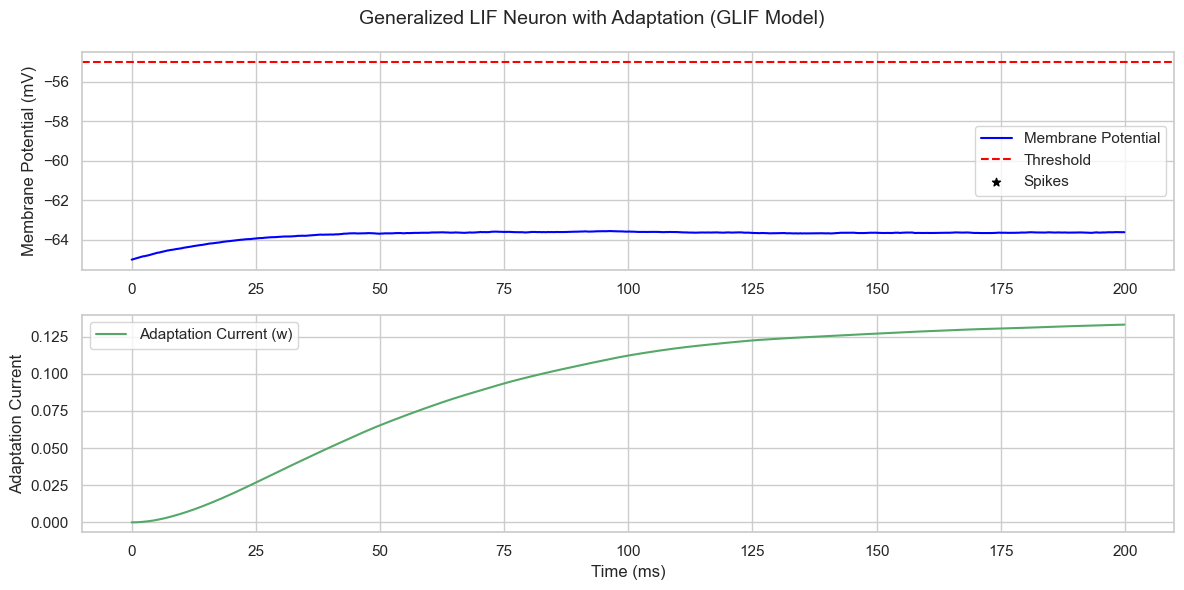

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def glif_neuron(V_rest, V_th, V_reset, tau, C, a, b, tau_w, I_ext, duration=200, dt=0.1):
    """
    Simulate a Generalized Leaky Integrate-and-Fire (GLIF) neuron with adaptation current.

    Parameters:
    - V_rest: Resting membrane potential (mV)
    - V_th: Spike threshold (mV)
    - V_reset: Reset potential after spike (mV)
    - tau: Membrane time constant (ms)
    - C: Membrane capacitance (nF)
    - a: Subthreshold adaptation conductance
    - b: Spike-triggered adaptation increment
    - tau_w: Adaptation time constant (ms)
    - I_ext: External input current array (nA)
    - duration: Total simulation time (ms)
    - dt: Time step (ms)

    Returns:
    - time: Array of simulation time points
    - Vm: Membrane potential over time
    - w: Adaptation current over time
    - spikes: List of spike times
    """
    time = np.arange(0, duration, dt)      # Create time vector
    Vm = np.zeros_like(time)               # Membrane potential array
    w = np.zeros_like(time)                # Adaptation current array
    Vm[0] = V_rest                         # Initialize at resting potential
    spikes = []                            # Store spike times

    # Loop through time to simulate neuron dynamics
    for t in range(1, len(time)):
        # --- Update membrane potential with leak, input, and adaptation ---
        # dV/dt = (-(V - V_rest) + I - w) / tau
        dV = (-(Vm[t-1] - V_rest) + I_ext[t-1] - w[t-1]) / tau
        Vm[t] = Vm[t-1] + dV * dt

        # --- Update adaptation current (subthreshold component) ---
        # dw/dt = (a(V - V_rest) - w) / tau_w
        dw = (a * (Vm[t-1] - V_rest) - w[t-1]) / tau_w
        w[t] = w[t-1] + dw * dt

        # --- Check for spike ---
        if Vm[t] >= V_th:
            spikes.append(time[t])        # Record spike time
            Vm[t] = V_reset               # Reset membrane potential
            w[t] += b                     # Add spike-triggered adaptation current

    return time, Vm, w, spikes

# ------------------------------------------------------------
# Parameters for adaptation behavior
# ------------------------------------------------------------
a = 0.1      # Subthreshold adaptation: how much voltage influences adaptation
b = 0.5      # Spike-triggered adaptation: increase in w after each spike
tau_w = 50   # Time constant for adaptation (ms)

# ------------------------------------------------------------
# Simulate GLIF neuron with noisy current input
# (assumes I_ext, V_rest, V_th, V_reset, tau, C, duration, dt already defined)
# ------------------------------------------------------------
time, Vm, w, spikes = glif_neuron(V_rest, V_th, V_reset, tau, C, a, b, tau_w, I_ext, duration, dt)

# ------------------------------------------------------------
# Plotting: Voltage and Adaptation Current over Time
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))

# Top subplot: Membrane potential with spike threshold and events
plt.subplot(211)
plt.plot(time, Vm, label='Membrane Potential', color='blue')
plt.axhline(V_th, color='red', linestyle='--', label='Threshold')
plt.scatter(spikes, [V_th]*len(spikes), color='black', marker='*', label='Spikes')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid(True)

# Bottom subplot: Adaptation current over time
plt.subplot(212)
plt.plot(time, w, 'g', label='Adaptation Current (w)')
plt.xlabel('Time (ms)')
plt.ylabel('Adaptation Current')
plt.legend()
plt.grid(True)

plt.suptitle('Generalized LIF Neuron with Adaptation (GLIF Model)', fontsize=14)
plt.tight_layout()
plt.show()


### Observations:
- Adaptation current builds up with spiking
- Causes spike frequency adaptation (slowing of firing rate)
- More biologically realistic than basic LIF

# Exercises for Participants

1. Modify the input current pattern and observe how the neuron responds
2. Experiment with different parameter values to see their effects
3. Implement a network of LIF neurons with synaptic connections
4. Compare the firing rates of IF, LIF, and gLIF models
5. Try implementing the Brian2 simulator version (see below)

---
# Brian2 Implementation
---
The raster plot visualizes the spike times of individual neurons in a population:

    - Each horizontal line represents one neuron.

    - Each dot or tick marks the time a specific neuron fired a spike.

    - Random input currents (drawn from a Gaussian distribution) cause different neurons to spike at different times and rates.

    This plot helps us analyze temporal firing patterns, such as synchrony, bursting, or rate variability across the population.

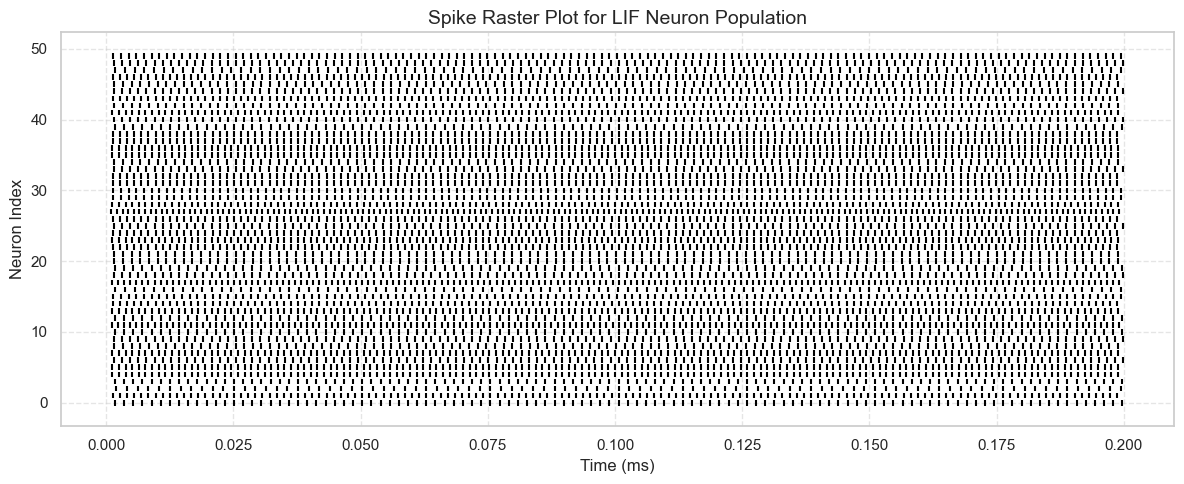

In [13]:
from brian2 import *
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Reset the Brian2 simulation environment
# ---------------------------------------------------------
start_scope()

# ---------------------------------------------------------
# Define network parameters
# ---------------------------------------------------------
N = 50                  # Number of neurons in the network
tau = 10*ms             # Membrane time constant (how quickly the neuron responds)
V_rest = -70*mV         # Resting membrane potential
V_reset = -70*mV        # Reset potential after a spike
V_thresh = -50*mV       # Threshold potential for firing
I_mean = 1.5*nA         # Mean external current (nA)
I_std = 0.2*nA          # Standard deviation of external current (adds heterogeneity)

# ---------------------------------------------------------
# Define the LIF neuron model equations
# dv/dt = [-(v - V_rest) + R*I] / tau
# Includes individual current (I) and resistance (R) per neuron
# ---------------------------------------------------------
eqs = '''
dv/dt = (-(v - V_rest) + R*I)/tau : volt
I : amp         # Input current (individual per neuron)
R : ohm         # Membrane resistance (shared or individual)
'''

# ---------------------------------------------------------
# Create the neuron group
# ---------------------------------------------------------
G = NeuronGroup(
    N, eqs,
    threshold='v > V_thresh',     # Spike occurs when voltage exceeds threshold
    reset='v = V_reset',          # Reset voltage after spike
    method='euler'                # Numerical integration method
)

# ---------------------------------------------------------
# Initialize neuron state variables
# ---------------------------------------------------------
G.v = V_rest                             # Set initial voltage to resting potential
G.R = 100*Mohm                           # Set resistance uniformly
G.I = I_mean + I_std * randn(N)         # Apply noisy input current to each neuron

# ---------------------------------------------------------
# Monitors to record simulation data
# ---------------------------------------------------------
M = StateMonitor(G, 'v', record=0)      # Record voltage of neuron 0 for inspection
spikemon = SpikeMonitor(G)              # Monitor all spike events

# ---------------------------------------------------------
# Run the simulation for 200 milliseconds
# ---------------------------------------------------------
run(200*ms)

# ---------------------------------------------------------
# Plot a spike raster: one row per neuron, one dot per spike
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.eventplot(
    spikemon.spike_trains().values(),   # All spike trains
    colors='black',                     # All spikes black
    linelengths=0.8                     # Vertical line length for each spike
)
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Neuron Index', fontsize=12)
plt.title('Spike Raster Plot for LIF Neuron Population', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 🧠 Exploring Input Distributions in LIF Neuron Populations

This simulation shows how a network of LIF neurons responds to heterogeneous input currents. The input current \( I \) is sampled from a **normal (Gaussian)** distribution by default.

---

### 🧪 Exercise: Try Different Input Distributions

Modify the line where `G.I` is defined to explore different types of input current distributions and observe how they affect spiking behavior.

#### 1. **Uniform Distribution**
```python
from numpy.random import uniform
G.I = uniform(I_mean - I_std, I_mean + I_std, N) * amp
```

#### 2. **Exponential Distribution**
```python
G.I = np.random.exponential(scale=I_mean, size=N) * amp
```

#### 3. **Bimodal Distribution**
```python
half = N // 2
G.I[:half] = I_mean * 0.8 + I_std * randn(half)
G.I[half:] = I_mean * 1.5 + I_std * randn(N - half)
```

---

### 🔍 Questions to Explore

- How does the **shape** of the distribution affect the firing rate and variability?
- Which distribution creates the **most synchronized** or **most irregular** firing?
- Plot a histogram of `G.I` values to better understand the distribution:
```python
plt.hist(G.I / nA, bins=15)
plt.xlabel("Input Current (nA)")
plt.ylabel("Number of Neurons")
plt.title("Distribution of Input Currents")
plt.show()
```


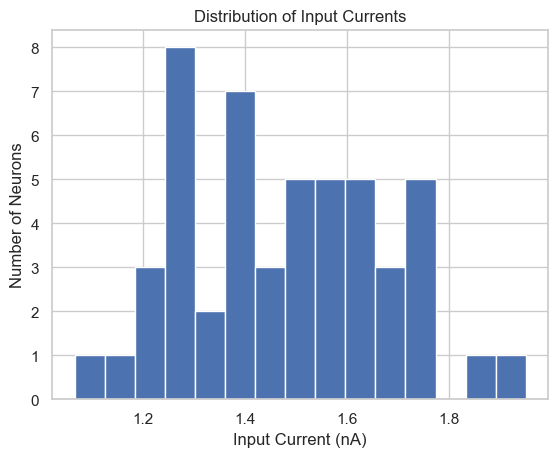

In [14]:
plt.hist(G.I / nA, bins=15)
plt.xlabel("Input Current (nA)")
plt.ylabel("Number of Neurons")
plt.title("Distribution of Input Currents")
plt.show()

---
# BONUS ON BRIAN2
---

WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([-70.        , -69.985     , -69.95538714, ..., -53.47168095,
       -53.03310874, -52.59606221]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


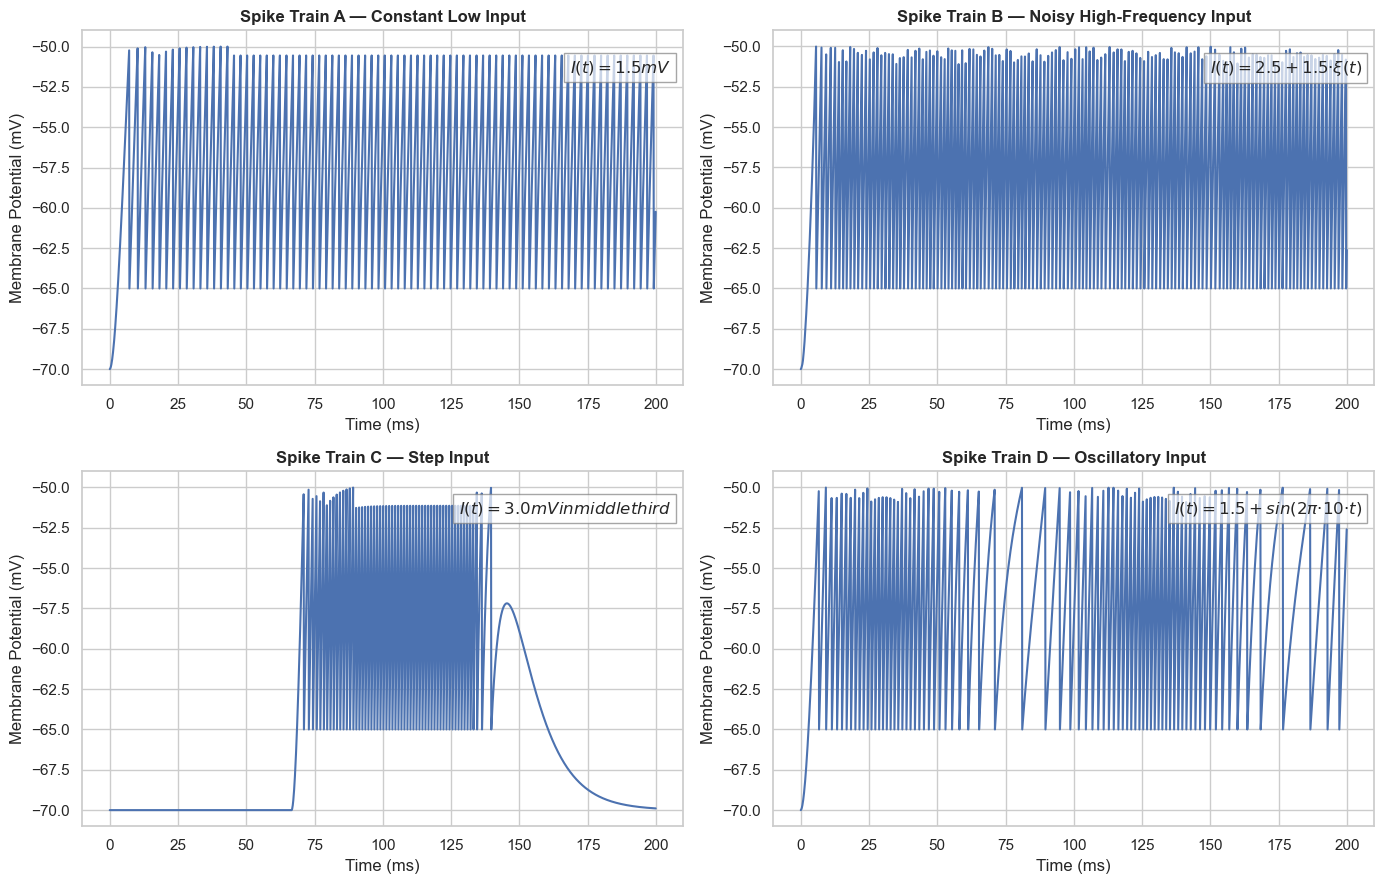

In [16]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

# Define mathematical expressions and labels for each input type
input_definitions = {
    "constant_low":    ("I(t) = 1.5 mV", "Constant Low Input"),
    "noisy_high":      ("I(t) = 2.5 + 1.5·ξ(t)", "Noisy High-Frequency Input"),
    "step":            ("I(t) = 3.0 mV in middle third", "Step Input"),
    "oscillatory":     ("I(t) = 1.5 + sin(2π·10·t)", "Oscillatory Input")
}

def generate_gLIF_response(input_type, duration=200*ms):
    # Reset Brian2 simulation environment
    start_scope()

    # Define generalized LIF neuron with an excitatory conductance variable (ge)
    eqs = '''
    dv/dt = (ge - (v - El)) / tau : volt
    dge/dt = -ge / tau_e : volt
    '''

    # Neuron model parameters
    El = -70*mV          # Resting potential
    tau = 10*ms          # Membrane time constant
    tau_e = 5*ms         # Synaptic conductance time constant
    V_th = -50*mV        # Spike threshold
    V_reset = -65*mV     # Reset potential after spike

    # Create a single neuron
    G = NeuronGroup(1, eqs, threshold='v > V_th', reset='v = V_reset', method='euler')
    G.v = El  # Initialize at resting potential

    # Create input current array based on input type
    time_points = int(duration / defaultclock.dt)
    input_array = np.zeros(time_points) * volt

    # Constant input current
    if input_type == "constant_low":
        input_array[:] = 1.5*mV
    # Noisy input: Gaussian noise added to mean
    elif input_type == "noisy_high":
        input_array[:] = (2.5 + 1.5*np.random.randn(time_points))*mV
    # Step input: applied only in the middle third of the duration
    elif input_type == "step":
        input_array[:time_points//3] = 0*mV
        input_array[time_points//3:2*time_points//3] = 3.0*mV
        input_array[2*time_points//3:] = 0*mV
    # Oscillatory sine wave input (10 Hz)
    elif input_type == "oscillatory":
        t_vals = np.linspace(0, float(duration/second), time_points)
        input_array[:] = (1.5 + 1.0*np.sin(2*np.pi*10*t_vals))*mV

    # Wrap input as a time-varying input (TimedArray)
    input_current = TimedArray(input_array, dt=defaultclock.dt)

    # Inject current into the neuron at each simulation step
    @network_operation(dt=defaultclock.dt)
    def inject_current():
        G.ge[0] += input_current(defaultclock.t)

    # Monitor membrane potential of the neuron
    M = StateMonitor(G, 'v', record=0)

    # Run simulation
    run(duration)

    # Return time, voltage trace, and input description
    return M.t/ms, M.v[0]/mV, input_definitions[input_type]

# Prepare list of inputs to simulate
inputs = ["constant_low", "noisy_high", "step", "oscillatory"]
titles = ["A", "B", "C", "D"]

# Simulate and store results for each input type
plots = [generate_gLIF_response(i) for i in inputs]

# Plotting responses in a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 9))
for i, ax in enumerate(axs.flat):
    t, v, (math_expr, label) = plots[i]
    ax.plot(t, v)  # Plot membrane potential
    ax.set_title(f"Spike Train {titles[i]} — {label}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Membrane Potential (mV)")
    
    # Display input equation as a label on the plot
    ax.text(0.98, 0.92, f"${math_expr}$", transform=ax.transAxes,
            fontsize=12, ha='right', va='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    ax.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("Interlude_SpikeTrain_WithEquations.png", dpi=300)
plt.show()


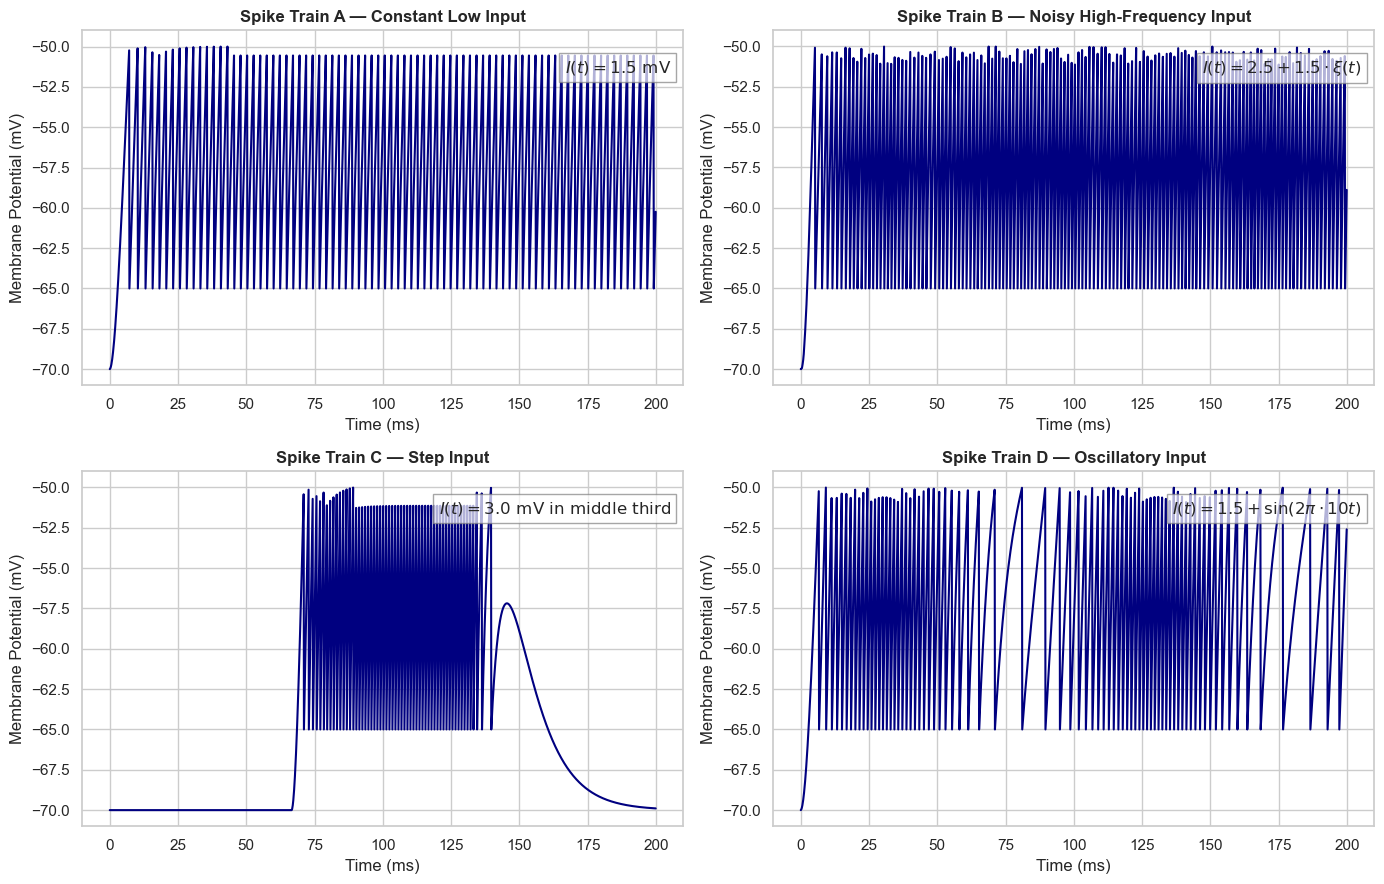

In [15]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------
# Define different types of input currents with math labels
# ----------------------------------------------------------
input_definitions = {
    "constant_low":    ("I(t) = 1.5\\ \\mathrm{mV}", "Constant Low Input"),
    "noisy_high":      ("I(t) = 2.5 + 1.5\\cdot\\xi(t)", "Noisy High-Frequency Input"),
    "step":            ("I(t) = 3.0\\ \\mathrm{mV}\\ \\text{in middle third}", "Step Input"),
    "oscillatory":     ("I(t) = 1.5 + \\sin(2\\pi\\cdot10t)", "Oscillatory Input")
}

def generate_gLIF_response(input_type, duration=200*ms):
    """
    Simulate a Generalized LIF neuron model (gLIF) with different types of external input.
    
    Parameters:
    - input_type: One of ['constant_low', 'noisy_high', 'step', 'oscillatory']
    - duration: Simulation time duration
    
    Returns:
    - t (ms): Time vector
    - v (mV): Membrane potential over time
    - label: Tuple with LaTeX math expression and label for the plot
    """
    start_scope()  # Reset Brian2 environment for fresh simulation

    # -----------------------------------------------
    # Define gLIF model equations:
    # v = membrane potential
    # ge = external conductance input (used as synaptic input current)
    # -----------------------------------------------
    eqs = '''
    dv/dt = (ge - (v - El)) / tau : volt       # LIF-like membrane voltage update
    dge/dt = -ge / tau_e : volt                # Exponentially decaying conductance
    '''

    # -----------------------------------------------
    # Model parameters
    # -----------------------------------------------
    El = -70*mV        # Resting potential
    tau = 10*ms        # Membrane time constant
    tau_e = 5*ms       # Conductance decay time constant
    V_th = -50*mV      # Spike threshold
    V_reset = -65*mV   # Reset value after spike

    # -----------------------------------------------
    # Create a single neuron group with above dynamics
    # -----------------------------------------------
    G = NeuronGroup(1, eqs, threshold='v > V_th', reset='v = V_reset', method='euler')
    G.v = El  # Initialize membrane potential to rest

    # -----------------------------------------------
    # Generate time-varying input based on input_type
    # -----------------------------------------------
    time_points = int(duration / defaultclock.dt)
    input_array = np.zeros(time_points) * volt

    if input_type == "constant_low":
        input_array[:] = 1.5*mV
    elif input_type == "noisy_high":
        input_array[:] = (2.5 + 1.5*np.random.randn(time_points)) * mV
    elif input_type == "step":
        input_array[:time_points//3] = 0*mV
        input_array[time_points//3:2*time_points//3] = 3.0*mV
        input_array[2*time_points//3:] = 0*mV
    elif input_type == "oscillatory":
        t_vals = np.linspace(0, float(duration/second), time_points)
        input_array[:] = (1.5 + 1.0*np.sin(2*np.pi*10*t_vals)) * mV

    # Wrap input array into a Brian2 TimedArray for time-varying input
    input_current = TimedArray(input_array, dt=defaultclock.dt)

    # -----------------------------------------------
    # Inject input conductance into neuron at each time step
    # -----------------------------------------------
    @network_operation(dt=defaultclock.dt)
    def inject_current():
        G.ge[0] += input_current(defaultclock.t)  # Add input to ge

    # -----------------------------------------------
    # Monitor voltage trace
    # -----------------------------------------------
    M = StateMonitor(G, 'v', record=0)

    # Run the simulation
    run(duration)

    return M.t/ms, M.v[0]/mV, input_definitions[input_type]  # Return time, voltage, label

# ----------------------------------------------------------
# Prepare multiple types of inputs for simulation and plotting
# ----------------------------------------------------------
inputs = ["constant_low", "noisy_high", "step", "oscillatory"]
titles = ["A", "B", "C", "D"]
plots = [generate_gLIF_response(i) for i in inputs]

# ----------------------------------------------------------
# Plot all four spike responses in a 2x2 grid
# ----------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 9))

for i, ax in enumerate(axs.flat):
    t, v, (math_expr, label) = plots[i]
    ax.plot(t, v, color='navy')
    ax.set_title(f"Spike Train {titles[i]} — {label}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Membrane Potential (mV)")
    
    # Annotate with LaTeX expression for input current
    ax.text(0.98, 0.92, f"${math_expr}$", transform=ax.transAxes,
            fontsize=12, ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    ax.grid(True)

plt.tight_layout()
plt.savefig("Interlude_SpikeTrain_WithEquations.png", dpi=300)  # Save high-quality figure
plt.show()


WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([-70.        , -69.985     , -69.95538714, ..., -53.47168095,
       -53.03310874, -52.59606221]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


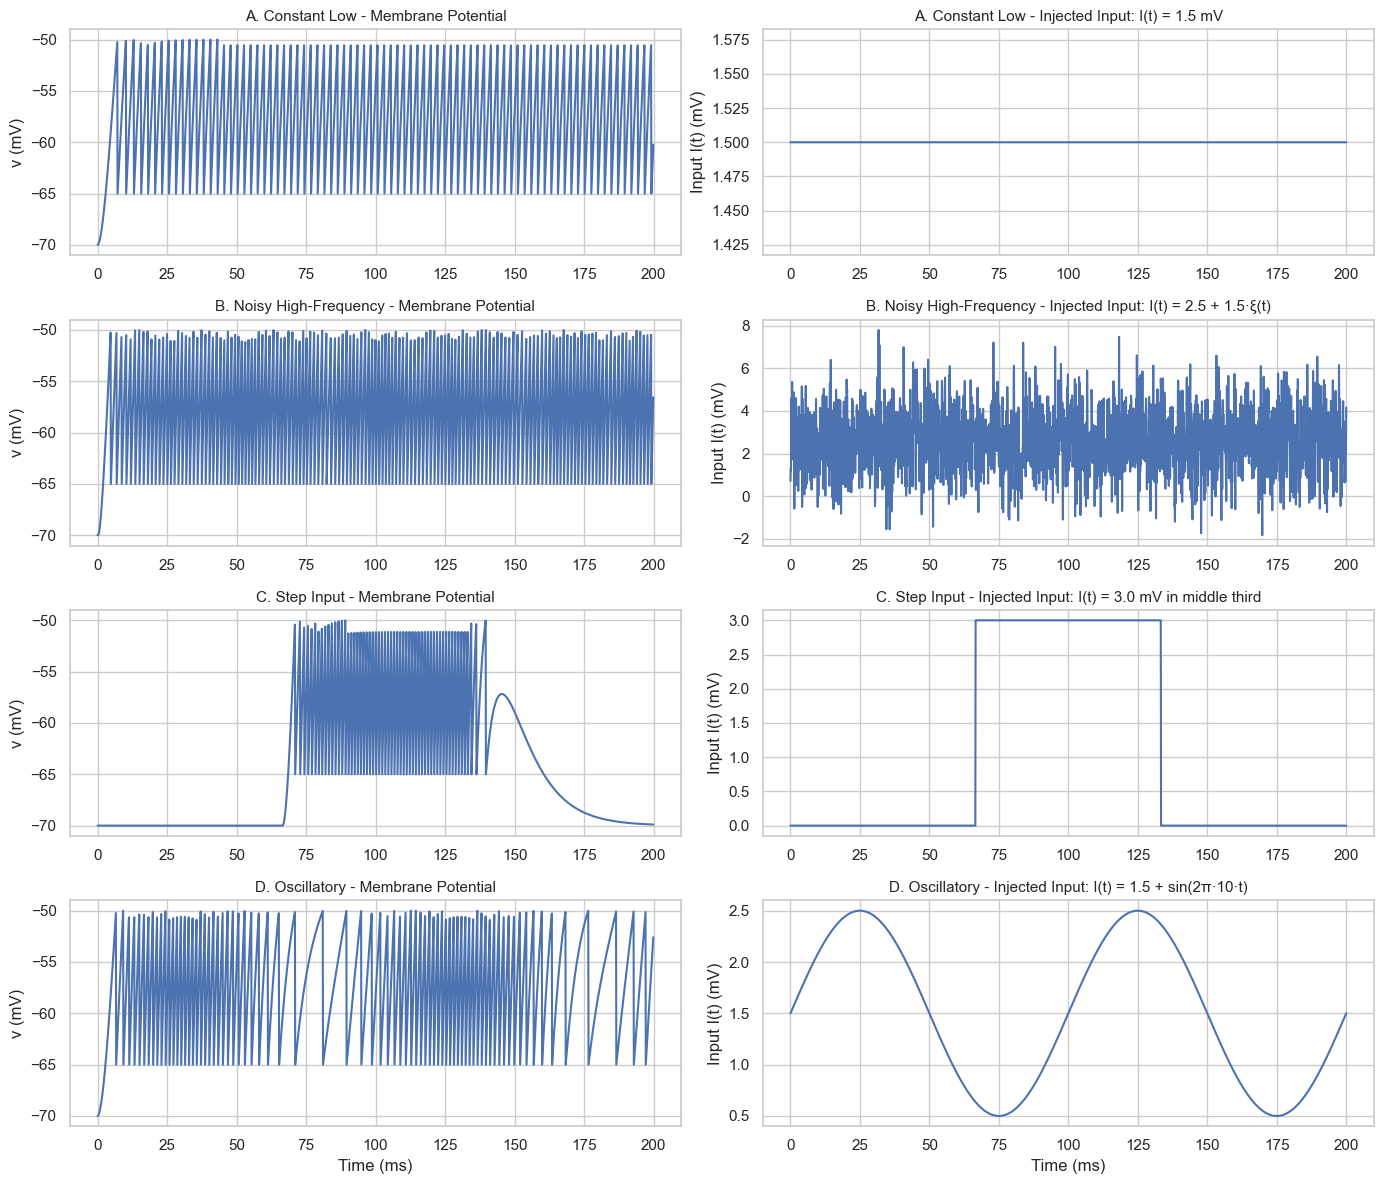

In [7]:

# 🎯 Try it: Plot the response of the gLIF model to each input

inputs = ["constant_low", "noisy_high", "step", "oscillatory"]
titles = ["A. Constant Low", "B. Noisy High-Frequency", "C. Step Input", "D. Oscillatory"]
plots = [generate_gLIF_response(i) for i in inputs]

fig, axs = plt.subplots(4, 2, figsize=(14, 12))
for i, (t, v, inp, label) in enumerate(plots):
    axs[i, 0].plot(t, v)
    axs[i, 0].set_title(f"{titles[i]} - Membrane Potential", fontsize=11)
    axs[i, 0].set_ylabel("v (mV)")
    axs[i, 0].grid(True)
    
    axs[i, 1].plot(t, inp)
    axs[i, 1].set_title(f"{titles[i]} - Injected Input: {label}", fontsize=11)
    axs[i, 1].set_ylabel("Input I(t) (mV)")
    axs[i, 1].grid(True)

axs[-1, 0].set_xlabel("Time (ms)")
axs[-1, 1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


---
# Conclusion
---
In this notebook we've implemented:
- Passive membrane dynamics
- Basic integrate-and-fire model
- Leaky integrate-and-fire model
- Generalized LIF with adaptation
- Used Brian2 Simulator

These simple models form the foundation for understanding more complex neural dynamics.

---
# References
---

1. Prof. Akinola Olayinka's LIF BioRTC Presentation
2. Theoretical Neuroscience by Peter Dayan and L.F. Abbott
3. Brian2 simulator documentation